#Setup

##Imports

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

import sys
sys.path.append('/content/gdrive/MyDrive/TFE crowd counting/CSRNet-pytorch')

import h5py
import scipy.io as io
import PIL.Image as Image
import numpy as np
import os
import glob
from matplotlib import pyplot as plt
from scipy.ndimage.filters import gaussian_filter 
import scipy
from scipy import spatial
from matplotlib import cm as CM
from image import *
                          
%matplotlib inline

Mounted at /content/gdrive


##Paths

In [ ]:
#set the paths for differents datasets

#Shangai dataset to reproduce results from the paper
'''
root = '/content/gdrive/My Drive/TFE crowd counting/ShanghaiTech_Crowd_Counting_Dataset/'
part_A_train = os.path.join(root,'part_A_final/train_data','images')
part_A_test = os.path.join(root,'part_A_final/test_data','images')
part_B_train = os.path.join(root,'part_B_final/train_data','images')
part_B_test = os.path.join(root,'part_B_final/test_data','images')
#partA
path_sets = [part_A_train,part_A_test]
#partB
#path_sets = [part_B_train,part_B_test]
'''
#Auditorium images
root = '/content/gdrive/My Drive/TFE crowd counting/Dataset/'
images_path = os.path.join(root,'images')
GT_path = os.path.join(root,'ground_truth')
path_sets = [images_path] #All images at the same place

img_paths = []
for path in path_sets:
    for img_path in glob.glob(os.path.join(path, '*.jpg')):
        img_paths.append(img_path)

#Utils

In [ ]:
#this is borrowed from https://github.com/davideverona/deep-crowd-counting_crowdnet

#This function create the density by using adaptive kernels
def gaussian_filter_density(gt):
    density = np.zeros(gt.shape, dtype=np.float32)
    gt_count = np.count_nonzero(gt)
    if gt_count == 0:
        return density
    pts = list(zip(np.nonzero(gt)[1],np.nonzero(gt)[0]))  
    pts = np.array(pts)
    leafsize = 2048
    # build kdtree
    tree = scipy.spatial.KDTree(pts.copy(), leafsize=leafsize)
    # query kdtree
    distances, locations = tree.query(pts, k=4)

    for i, pt in enumerate(pts):
        pt2d = np.zeros(gt.shape, dtype=np.float32)
        pt2d[pt[1],pt[0]] = 1.
        if gt_count > 1:
            sigma = (distances[i][1]+distances[i][2]+distances[i][3])*0.1
        else:
            sigma = np.average(np.array(gt.shape))/2./2. #case: 1 point
        density += scipy.ndimage.filters.gaussian_filter(pt2d, sigma, mode='constant')
    return density

In [ ]:
#Method to generate h5 ground_truth file based on the paths to the images file
#Crowded = False -> Usage of only gaussian // Crowded = True -> Usage of geometric adaptive kernel

def gt_gen(img_paths, crowded = True ,Verbose = False):
  count=0
  for img_path in img_paths:
      mat = io.loadmat(img_path.replace('.jpg','.mat').replace('images','ground_truth').replace('IMG_','GT_IMG_'))
      img= plt.imread(img_path)
      k = np.zeros((img.shape[0],img.shape[1]))
      gt = mat["image_info"][0,0][0,0][0]
      for i in range(0,len(gt)):
          if int(gt[i][1])<img.shape[0] and int(gt[i][0])<img.shape[1]:
              k[int(gt[i][1]),int(gt[i][0])]=1.
      
      #density generation for crowded image
      if crowded:
        k = gaussian_filter_density(k)
      #density generation for non crowded image
      else:
        k = gaussian_filter(k,15)


      with h5py.File(img_path.replace('.jpg','.h5').replace('images','ground_truth'), 'w') as hf:
              hf['density'] = k
      if Verbose:
        print("image "+str(count) + "/" + str(len(img_paths))+ " done")
        count+=1


#GT Generation

In [ ]:
gt_gen(img_paths)

#Visualization

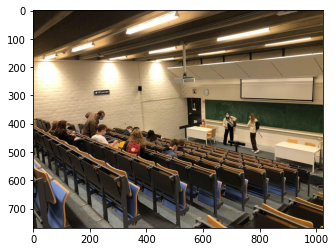

In [ ]:
plt.imshow(Image.open(img_paths[12]))

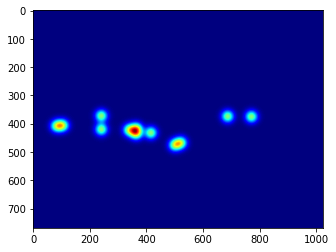

In [ ]:
gt_file = h5py.File(img_paths[12].replace('.jpg','.h5').replace('images','ground_truth'),'r')
groundtruth = np.asarray(gt_file['density'])
plt.imshow(groundtruth,cmap=CM.jet)

In [ ]:
print(np.sum(groundtruth))

12.000000000000002
